<small><i>This notebook was created by Franck Iutzeler, Jerome Malick and Yann Vernaz (2016).</i></small>
<!-- Credit (images) Jeffrey Keating Thompson. -->

<center><img src="UGA.png" width="30%" height="30%"></center>
<center><h3>Master of Science in Industrial and Applied Mathematics (MSIAM)</h3></center>
<hr>
<center><h1>Convex and distributed optimization</h1></center>
<center><h2>Part II - Classification (3h + 3h home work)</h2></center>

# Outline

In this Lab, we will investigate some gradient-based and proximal algorithms on the binary classification problems with logistic regression.

# Supervised Classification and Logistic Regression

### Machine Learning as an Optimization problem

We have some *data*  $\mathcal{D}$ consisting of $m$ *examples* $\{d_i\}$; each example consisting of a *feature* vector $a_i\in\mathbb{R}^d$ and an *observation* $b_i\in \mathcal{O}$: $\mathcal{D} = \{[a_i,b_i]\}_{i=1..m}$ .


The goal of *supervised learning* is to construct a predictor for the observations when given feature vectors.


A popular approach is based on *linear models* which are based on finding a *parameter* $x$ such that the real number $\langle a_i , x \rangle$ is used to predict the value of the observation through a *predictor function* $g:\mathbb{R}\to \mathcal{O}$: $g(\langle a_i , x \rangle)$ is the predicted value from $a_i$.


In order to find such a parameter, we use the available data and a *loss* $\ell$ that penalizes the error made between the predicted $g(\langle a_i , x \rangle)$ and observed $b_i$ values. For each example $i$, the corresponding error function for a parameter $x$ is $f_i(x) =   \ell( g(\langle a_i , x \rangle) ; b_i )$. Using the whole data, the parameter that minimizes the total error is the solution of the minimization problem
$$ \min_{x\in\mathbb{R}^d} \frac{1}{m} \sum_{i=1}^m f_i(x) = \frac{1}{m} \sum_{i=1}^m  \ell( g(\langle a_i , x \rangle) ; b_i ). $$


### Binary Classification with Logisitic Regression

In our setup, the observations are binary: $\mathcal{O} = \{-1 , +1 \}$, and the *Logistic loss* is used to form the following optimization problem
\begin{align*}
\min_{x\in\mathbb{R}^d } f(x) := \frac{1}{m}  \sum_{i=1}^m  \log( 1+\exp(-b_i \langle a_i,x \rangle) ).
\end{align*}

Under some statistical hypotheses, $x^\star = \arg\min f(x)$ maximizes the likelihood of the labels knowing the features vector. Then, for a new point $d$ with features vector $a$, 
$$ p_1(a) = \mathbb{P}[d\in \text{ class }  +1] = \frac{1}{1+\exp(-\langle a;x^\star \rangle)} $$
Thus, from $a$, if $p_1(a)$ is close to $1$, one can decide that $d$ belongs to class $1$; and the opposite decision if $p(a)$ is close to $0$. Between the two, the appreciation is left to the data scientist depending on the application.


# Supervised classification datasets



### Reading the dataset

We will use LibSVM formatted data, meaning that each line of the file (i.e. each example) will have the form

<tt>class feature_number1:feature_value1 feature_number2:feature_value2 ... feature_number$n_i$:feature_value$n_i$ </tt>

You may read such a file using MLUtils's <a href="http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.util.MLUtils.loadLibSVMFile">`loadLibSVMFile`</a> routine on the supervised classification datasets below.

The elements of the produced RDD have the form of <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint">`LabeledPoints`</a> composed of a label `example.label` corresponding to the class (+1 or -1) and a feature vector `example.features` generally encoded as a <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.SparseVector">`SparseVector`</a>.


In [28]:
# set up spark environment (using Spark local mode set to # cores on your machine)
#import findspark
#findspark.init()

from pyspark import SparkContext, SparkConf

conf = SparkConf()
conf.setMaster("local[*]")
conf.setAppName("MSIAM part II - Logistic Regression")

sc = SparkContext(conf = conf)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=MSIAM part II - Logistic Regression, master=local[*]) created by __init__ at <ipython-input-1-1674fdc40741>:11 

We remind you that you can access this interface (Spark UI) by simply opening http://localhost:4040 in a web browser.

In [29]:
# path to LibSVM Datasets
#LibSVMHomeDir="data/LibSVM/"
LibName="ionosphere.txt"             # a small dataset to begin with
#LibName="rcv1_train.binary"          # a bigger one 

__Question 1__
> Form an RDD from the selected dataset.

> Count the number of examples, features, the number of examples of class '+1' and the density of the dataset.

In [30]:
from pyspark.mllib.util import MLUtils
data = MLUtils.loadLibSVMFile(sc, LibName).setName("LibSVM")
#data = sc.textFile("ionosphere.txt")#.setName("LibSVM")
N = data.count() # number of examples
D = len(data.first().features) # number of features
nb_pos_samples = data.filter(lambda x: x.label == 1).count()
nb_neg_samples = data.filter(lambda x: x.label == -1).count()
nb_nonzero_vals = data.map(lambda x: x.features.numNonzeros()).reduce(lambda x, y: x + y)
density = 1. * nb_nonzero_vals / (N * D)

print("number of examples (N) = %d" % N)
print("number of features (D) = %d" % D)
print("number of examples of class +1 = %d" % nb_pos_samples)
print("number of examples of class -1 = %d" % nb_neg_samples)
print("density = %f" % density)
print(nb_nonzero_vals)

number of examples (N) = 351
number of features (D) = 34
number of examples of class +1 = 225
number of examples of class -1 = 126
density = 0.884113
10551


### Preprocessing

An important first step for learning by regression is to preprocess the dataset. This processing usually consists in:
* Adding an intercept, that is an additional feature equal to one for all examples (statistically, this accounts for the fact that the two classes may be imbalanced).
* For the dense datasets:
    *  normalize to have zero-mean and unit variance for every feature (except the interecept for instance.
* For sparse datasets:
    * normalize so that the feature vector has unit $\ell_2$ norm for each example.

This does not really change the problem but it will ease the convergence of the applied optimization algorithms.

__Question 2__
> Form a new RDD with the scaled version of the dataset.

> Check that the number of examples, features, and the density is correct.

In [31]:
import numpy as np
from operator import add
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint

# as variance can be zero for some features, we will remove those column and insert them back
def normalize_sample(x):
    new_features = (x.features.toArray() - means) / np.sqrt(variance)
    new_features = np.append(new_features, 1)
    features_sparse_vector = SparseVector(np.shape(means)[0] + 1,
                                          np.nonzero(new_features)[0],
                                          new_features[np.nonzero(new_features)])
    return LabeledPoint(x.label, features_sparse_vector)

In [32]:
print(np.__version__)

first = data.first()
print(first)

features = first.features
print(features)

np_features = features.toArray()
print(np_features)
# data_mapped = data.map(lambda x: x.features)
# first_mapped = data_mapped.first()
# print(first_mapped)


1.10.4
(1.0,(34,[0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33],[1.0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.0,0.0376,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.3409,0.42267,-0.54487,0.18641,-0.453]))
(34,[0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33],[1.0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.0,0.0376,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.3409,0.42267,-0.54487,0.18641,-0.453])
[ 1.       0.       0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708
  1.       0.0376   0.85243 -0.17755  0.59755 -0.44945  0.60536 -0.38223
  0.84356 -0.38542  0.58212 -0.32192  0.56971 -0.29674  0.36946 -0.47357
  0.56811 -0.51171  0.41078 -0.46168  

In [33]:
means = data.map(lambda x: x.features.toArray()).reduce(add) / N
print('means:')
print(means)

variance = data.map(lambda x: (x.features.toArray() - means) ** 2).reduce(add) / N
print('variance:')
print(variance)

# as we can not divide by zero, we fix the values of variance where it is 0 (the second column which is empty)
variance[np.argwhere(variance == 0)] = 1

data_normalized = data.map(normalize_sample)

print(data_normalized.first())
      
new_means = data_normalized.map(lambda x: x.features.toArray()).reduce(add) / N
print('means in the normalized data:')
print(new_means)

new_variance = data_normalized.map(lambda x: (x.features.toArray() - new_means) ** 2).reduce(add) / N
print('variance in the normalized data:')
print(new_variance)


new_N = data_normalized.count() # number of examples
new_D = len(data_normalized.first().features.toArray()) # number of features
new_nb_nonzero_vals = data_normalized.map(lambda x: x.features.numNonzeros()).reduce(add)
new_density = 1. * new_nb_nonzero_vals / (new_N * new_D)

print("number of examples (N) in the normalized data = %d" % new_N)
print("new number of features (D) in the normalized data = %d" % new_D)
print("density in the normalized data = %f" % new_density)

means:
[ 0.78347578  0.          0.64134185  0.04437188  0.60106789  0.115889
  0.55009507  0.11936037  0.51184809  0.18134538  0.47618265  0.15504046
  0.4008012   0.09341368  0.34415915  0.07113234  0.381949   -0.00361681
  0.3593896  -0.0240247   0.33669547  0.0082959   0.3624755  -0.05740575
  0.39613467 -0.07118687  0.5416408  -0.06953761  0.37844519 -0.02790709
  0.35251373 -0.00379376  0.34936365  0.01448011]
variance:
[ 0.3861657   0.          0.24700772  0.19430949  0.26948603  0.211741
  0.24201626  0.27040786  0.25638293  0.2334447   0.31662351  0.24414675
  0.38601268  0.24420121  0.42496998  0.20950509  0.38086098  0.24606941
  0.39109271  0.26867235  0.37083107  0.26773094  0.36349662  0.27741755
  0.33365214  0.25783     0.26570809  0.30166587  0.33069932  0.25730253
  0.32566278  0.26300717  0.27239872  0.21871485]
(1.0,(35,[0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34],[0.348433280269,0.712372367309,-0.234257237563,0.4842

#  Initialization

We will set up here the variables, and the training versus testing dataset. Indeed, we will take a portion of the dataset to learn called the `learning set`, say $95$%, and we will test our predictions on the rest, the `testing set`.

__Question 3__

>  Split the scaled dataset into a training and a testing set. For instance, you may use the function <a href="http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit">`randomSplit`</a>.

> Count the number of examples, and subjects in class '+1' in each set.

In [34]:
learn, test = data_normalized.randomSplit([0.95, 0.05])

N_learn = learn.count()
N_test = test.count()

nb_pos_samples_learn = learn.filter(lambda x: x.label == 1).count()
nb_pos_samples_test = test.filter(lambda x: x.label == 1).count()

print('N_learn = %d, N_test = %d' %(N_learn, N_test))
print('number of examples of class +1 in learn = %d', nb_pos_samples_learn)
print('number of examples of class +1 in test = %d', nb_pos_samples_test)


N_learn = 337, N_test = 14
number of examples of class +1 in learn = %d 218
number of examples of class +1 in test = %d 7


In [35]:
learn, test = data.randomSplit([0.95, 0.05])
N_learn = learn.count()
N_test = test.count()

nb_pos_samples_learn = learn.filter(lambda x: x.label == 1).count()
nb_pos_samples_test = test.filter(lambda x: x.label == 1).count()

print('N_learn = %d, N_test = %d' %(N_learn, N_test))
print('number of examples of class +1 in learn = %d', nb_pos_samples_learn)
print('number of examples of class +1 in test = %d', nb_pos_samples_test)

N_learn = 332, N_test = 19
number of examples of class +1 in learn = %d 214
number of examples of class +1 in test = %d 11


#  Minimization of the logistic loss with the Gradient algorithm

The goal of this section is to: 
1. Compute gradients of the loss functions.
2. Implement a Gradient algorithm.
3. Observe the prediction accuracy of the developed methods.

__Question 4__
>Define a routine computing functional loss and gradient from one example 

For a Labeled point <tt>example</tt> (`LabeledPoint(example.label,example.features)`) that we denoted $(b_i,a_i)$ and a regressor <tt>x</tt>, compute $f_i(x) = \log(1+\exp(-b_i \langle a_i,x\rangle) )$ and $\nabla f_i(x)$.


In [36]:
def logistic_loss_per_example(example,x):
    """ Computes the logistic loss for a Labeled point
    Args:
        example: a labeled point
        x: regressor
    Returns:
        real value: l 
    """
    res = np.log(1 + np.exp(- example.label * np.dot(example.features.toArray(), x)))
    return res 

In [37]:
def logistic_grad_per_example(example,x):
    """ Computes the logistic gradient for a Labeled point
    Args:
        example: a labeled point
        x: regressor
    Returns:
        numpy array: g 
    """
    denom = (1 + np.exp(example.label * np.dot(example.features.toArray(), x)))
    res = - example.label * example.features.toArray() / denom
    return res


__Question 5__
>Implement a gradient descent algorithm to minimize
\begin{align*}
\min_{x\in\mathbb{R}^d } f(x) := \frac{1}{m}  \sum_{i=1}^m  \log( 1+\exp(-b_i \langle a_i,x \rangle) ) = \frac{1}{m}  \sum_{i=1}^m f_i(x).
\end{align*}
>by 
* defining a function taking a stepsize and a maximal number of iterations and returning the final point as well as the value of $f(x)$ at each iteration. 
* running `x, f_tab = grad_algo(gamma,MAX_ITE)`


For the choice of the stepsize, we help you by provinding you an upper bound on the Lipschitz constant $L$ of $\nabla f$:

$ L \leq L_b = \max_i 0.25 \|a_i\|_2^2$.

In [38]:
def grad_algo(trainRDD, gamma, max_iter):
    print('start grad_algo with gamma = %f, max_iter = %d' % (gamma, max_iter))
    f_tab = [1.]
    N = trainRDD.count()
    x = np.zeros(len(trainRDD.first().features.toArray())) # init values = 0
    for i in range(max_iter): # maybe change to convergence criterion
        sg = trainRDD.map(lambda ex: logistic_grad_per_example(ex, x)).reduce(add) / N
        x -= gamma * sg
        ll = trainRDD.map(lambda ex: logistic_loss_per_example(ex, x)).reduce(add) / N
        f_tab.append(ll)
        print('[iter %d] f(x) = %f' %(i, ll))
    print('done')
    return x, f_tab

In [39]:
max_example_norm = learn.map(lambda x: np.sqrt(x.features.dot(x.features))).reduce(lambda x,y: x if x > y else y)
L_b = 0.25 * max_example_norm # we take the upperbound
gamma = 2. / L_b # works better with e.g. 8. / L_b
max_iter = 100 # first guess

(x_opt, f_tab) = grad_algo(learn, gamma, max_iter)

start grad_algo with gamma = 1.392621, max_iter = 100
[iter 0] f(x) = 0.565507
[iter 1] f(x) = 0.488141
[iter 2] f(x) = 0.469332
[iter 3] f(x) = 0.455753
[iter 4] f(x) = 0.444950
[iter 5] f(x) = 0.435923
[iter 6] f(x) = 0.428154
[iter 7] f(x) = 0.421339
[iter 8] f(x) = 0.415276
[iter 9] f(x) = 0.409827
[iter 10] f(x) = 0.404890
[iter 11] f(x) = 0.400387
[iter 12] f(x) = 0.396257
[iter 13] f(x) = 0.392450
[iter 14] f(x) = 0.388927
[iter 15] f(x) = 0.385654
[iter 16] f(x) = 0.382602
[iter 17] f(x) = 0.379749
[iter 18] f(x) = 0.377073
[iter 19] f(x) = 0.374557
[iter 20] f(x) = 0.372186
[iter 21] f(x) = 0.369947
[iter 22] f(x) = 0.367827
[iter 23] f(x) = 0.365816
[iter 24] f(x) = 0.363906
[iter 25] f(x) = 0.362088
[iter 26] f(x) = 0.360355
[iter 27] f(x) = 0.358701
[iter 28] f(x) = 0.357119
[iter 29] f(x) = 0.355605
[iter 30] f(x) = 0.354154
[iter 31] f(x) = 0.352761
[iter 32] f(x) = 0.351423
[iter 33] f(x) = 0.350136
[iter 34] f(x) = 0.348897
[iter 35] f(x) = 0.347703
[iter 36] f(x) = 0.3

__Question 6__

> Plot the functional value versus the iterations.

> Investigate if the computations are distributed over different threads.

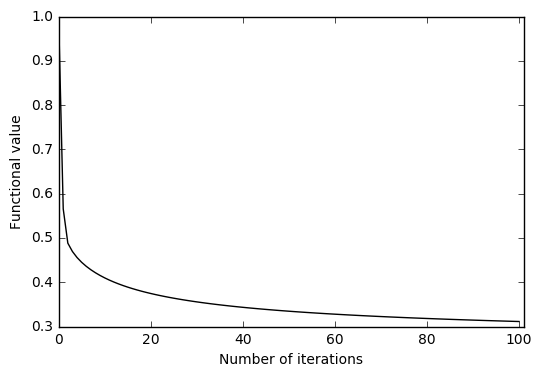

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure()
plt.plot(range(max_iter+1), f_tab, color="black", linewidth=1.0, linestyle="-")
plt.xlim(0, max_iter+1)
plt.xlabel('Number of iterations')
plt.ylabel('Functional value')
plt.show()

# Regularized logisitic regression

In addition to the loss, it is usual to add a regularization term of the form
$$ r(x) = \lambda_1 \|x\|_1 + \lambda_2 \|x\|^2_2 $$

The first part promotes sparsity of the iterates while the second part prevents over-fitting. 
This kind of regularization is often called:
- *elastic-net* when $ \lambda_1$ and $ \lambda_2$ are non-null
- $\ell_1$ when $\lambda_2 = 0$
- *Tikhonov* when $\lambda_1 = 0$

The full optimization problems now writes
\begin{align*}
\min_{x\in\mathbb{R}^d } g(x) =  \frac{1}{m}  \sum_{i=1}^m  \log( 1+\exp(-b_i \langle a_i,x \rangle) ) +  \lambda_1 \|x\|_1 + \lambda_2 \|x\|^2_2
\end{align*}


__Question 7__

> Which part of $g$ is smooth, which part is not? Write $g$ as 
$$ g(x) =  \frac{1}{m}  \sum_{i=1}^m s_i(x) + n(x)  $$
where the $(s_i)$ are smooth function and $n$ is non smooth. 

> Define a function `regularized_logistic_grad_per_example(examples,x)` returning the gradient of the smooth part per example (i.e. $\nabla s_i(x)$)

> Define a function `n_prox(x,gamma)` returning the proximal operator of the non-smooth part (i.e. $\mathbf{prox}_{\gamma n}(y)$)

we recall that
$$ \mathbf{prox}_{\gamma n}(y) = \arg\min_x\left\{ n(x) + \frac{1}{2\gamma} \|x-y\|_2^2 \right\} $$

In [ ]:
def regularized_logistic_loss_per_example(example,x,lambda_1,lambda_2):
    """ Computes the logistic loss for a Labeled point
    Args:
        example: a labeled point
        x: regressor
    Returns:
        real value: l 
    """
    res = np.log(1 + np.exp(- example.label * np.dot(example.features.toArray(), x))) + lambda_2*np.dot(x,x) +lambda_1*sum(abs(x))
    return res 


def regularized_logistic_grad_per_example(example, x, lambda_2):
    """ Computes the logistic gradient for a Labeled point of smooth part of regularized logistic loss
    Args:
        example: a labeled point
        x: regressor
    Returns:
        numpy array: g 
    """
    denom = (1 + np.exp(example.label * np.dot(example.features.toArray(), x)))
    res = - example.label * example.features.toArray() / denom  + 2*lambda_2*x
    return res

def n_prox(y,gamma,lambda_1):
    x = y.copy()
    for i in range(np.size(y)):
        if y[i] > gamma: 
            x[i] = y[i] - gamma*lambda_1
        elif y[i] < -gamma:
            x[i] = y[i] + gamma*lambda_1
        else:
            x[i] = 0
    return x

__Question 8__

> Compute a proximal gradient algorithm for computing a solution of
$$ \min_x  f(x) + r(x) = \frac{1}{m}  \sum_{i=1}^m  \log( 1+\exp(-b_i \langle a_i,x \rangle) ) + \lambda_1 \|x\|_1 + \lambda_2 \|x\|^2_2 $$


Hint: An admissible stepsize can be found by taking $\gamma = 1/L_{b2}$ with  $ L_b = \max_i 0.25 \|a_i\|_2^2 + 2\lambda_2$.

In [ ]:
def proximal_gradient_algorithm(trainRDD, gamma, max_iter,lambda_1,lambda_2):
    print('start grad_algo with gamma = %f, max_iter = %d' % (gamma, max_iter))
    f_tab = [1.]
    N = trainRDD.count()
    x = np.zeros(len(trainRDD.first().features.toArray())) # init values = 0
    for i in range(max_iter): # maybe change to convergence criterion
        sg = trainRDD.map(lambda ex: regularized_logistic_grad_per_example(ex, x,lambda_2)).reduce(add) / N
        x -= gamma * sg
        x = n_prox(x,gamma,lambda_1)
        ll = trainRDD.map(lambda ex: regularized_logistic_loss_per_example(ex, x,lambda_1,lambda_2)).reduce(add) / N
        f_tab.append(ll)
        print('[iter %d] f(x) = %f' %(i, ll))
    print('done')
    return x, f_tab

In [ ]:
lambda_1 = 2
lambda_2 = 1
max_example_norm = learn.map(lambda x: np.sqrt(x.features.dot(x.features.toArray()))).reduce(lambda x,y: x if x > y else y)
L_b = 0.25 * max_example_norm + 2*lambda_2 # we take the upperbound
gamma = 0.5 / L_b # works better with e.g. 8. / L_b
max_iter = 10 # first guess

(x_opt, f_tab) =  proximal_gradient_algorithm(learn, gamma, max_iter,lambda_1,lambda_2)

__Question 9__

> Examine the behavior and output of your proximal gradient algorithm with different values of $\lambda_1$, $\lambda_2$. What do you observe in terms of sparsity of the solution and convergence rate of the algorithm?

In [ ]:
max_example_norm = learn.map(lambda x: np.sqrt(x.features.dot(x.features))).reduce(lambda x,y: x if x > y else y)

for i in range(10):
    lambda_1 = i
    lambda_2 = 1
    L_b = 0.25 * max_example_norm + 2*lambda_2 # we take the upperbound
    gamma = 2. / L_b # works better with e.g. 8. / L_b
    max_iter = 100 # first guess
    (x_opt, f_tab) = proximal_gradient_algorithm(learn, gamma, max_iter,lambda_1,lambda_2)
    

start grad_algo with gamma = 0.582048, max_iter = 100
[iter 0] f(x) = 0.693147
[iter 1] f(x) = 0.693147
[iter 2] f(x) = 0.693147
[iter 3] f(x) = 0.693147
[iter 4] f(x) = 0.693147
[iter 5] f(x) = 0.693147
[iter 6] f(x) = 0.693147
[iter 7] f(x) = 0.693147
[iter 8] f(x) = 0.693147
[iter 9] f(x) = 0.693147
[iter 10] f(x) = 0.693147
[iter 11] f(x) = 0.693147
[iter 12] f(x) = 0.693147
[iter 13] f(x) = 0.693147
[iter 14] f(x) = 0.693147
[iter 15] f(x) = 0.693147
[iter 16] f(x) = 0.693147
[iter 17] f(x) = 0.693147
[iter 18] f(x) = 0.693147
[iter 19] f(x) = 0.693147
[iter 20] f(x) = 0.693147
[iter 21] f(x) = 0.693147
[iter 22] f(x) = 0.693147
[iter 23] f(x) = 0.693147
[iter 24] f(x) = 0.693147
[iter 25] f(x) = 0.693147
[iter 26] f(x) = 0.693147
[iter 27] f(x) = 0.693147
[iter 28] f(x) = 0.693147
[iter 29] f(x) = 0.693147
[iter 30] f(x) = 0.693147
[iter 31] f(x) = 0.693147
[iter 32] f(x) = 0.693147
[iter 33] f(x) = 0.693147
[iter 34] f(x) = 0.693147
[iter 35] f(x) = 0.693147
[iter 36] f(x) = 0.6

__Question 10__

> Write a function that evaluates the accuracy of the classification on the training dataset.

> Investigate how this accuracy change when playing with the regularization terms


In [71]:
def accuracy(learn, test, lambda_1, lambda_2):
    (x_opt, f_tab) = proximal_gradient_algorithm(learn, gamma, max_iter,lambda_1,lambda_2)
    p = test.map(lambda ex: 1./(1+exp(−np.dot(ex,x_opt)))
    res = p.map(lambda ex: np.abs(np.sign(ex - 0.5) - test.labels()).reduce(add)
    return res


SyntaxError: invalid character in identifier (<ipython-input-71-fd74c5210587>, line 3)

# To go further




### Accelerations

A popular acceleration method to improve the convergence rate of proximal gradient algorithm is the addition of inertia. That is, contructing the next gradient input by a combination of the last two outputs.


In particular, Nesterov's acceleration is the most popular form of inertia. It writes
$$ \left\{ \begin{array}{l}   y_{k+1} = \mathbf{prox\_grad}(x_k) \\ x_{k+1} = y_{k+1} + \alpha_{k+1} (y_{k+1} - y_k)  \end{array} \right. $$ 
with
* $\mathbf{prox\_grad}$ the proximal gradient operation
* $(\alpha_{k})$ the inertial sequence defined as $\alpha_k = \frac{t_k-1}{t_{k+1}}$ and $t_0 = 0$ and $t_{k+1} = \frac{1+\sqrt{1+4t_k^2}}{2}$

__Question 11__

> Implement a fast proximal gradient with this kind of inertia (This algorithm is often nicknamed FISTA).

> Compare the convergence speed with the vanilla proximal gradient algorithm

### Incremental methods

When dimension increases, incremental algorithms are often priviledged. 

A possible incremental algorithm for a problem such as regularized logistic regression is MISO (see *J Mairal. Incremental Majorization-Minimization Optimization with Application to Large-Scale Machine Learning. SIAM Journal on Optimization,2015 and ICML 2014.*):

* Draw randomly a sample $n$
* Compute $x^n_{k+1} = \mathbf{prox}_{\gamma g} (\bar{x}_k) - \gamma \nabla f_n(\mathbf{prox}_{\gamma g} (\bar{x}_k) )$
* For all $i\neq n$, $x^i_{k+1}=x^i_k$ 
* Compute new $\bar{x}_{k+1} = \frac{1}{m} \sum_{j=1}^m x^j_{k+1}$
 

__Question 12__

> Implement this incremental algorithm and compare with the previous algorithms in terms of convergence time and functional value versus number of passes over the data.